# Signal Comparison: Original vs. Custom Processing Function

This notebook allows you to:
1. Load an audio file (supports .m4a, .wav, .mp3, .csv)
2. Define your own processing function with configurable parameters
3. Compare the original signal with the processed signal
4. Visualize differences in time domain, frequency domain, and spectrogram

## How to Use:
1. **Load Audio**: Select and load an audio file
2. **Define Function**: Edit the `process_signal()` function with your custom processing logic
3. **Configure Parameters**: Adjust parameters in the configuration section
4. **Compare**: Run the comparison cells to see visualizations


In [13]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy import signal as scipy_signal
from pathlib import Path
import os

# Try to import audio libraries
try:
    import librosa
    HAS_LIBROSA = True
except ImportError:
    HAS_LIBROSA = False
    print("Warning: librosa not found. Install with: pip install librosa")
    print("Will try alternative methods for audio loading.")

try:
    from scipy.io import wavfile
    HAS_WAVFILE = True
except ImportError:
    HAS_WAVFILE = False

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print(f"librosa available: {HAS_LIBROSA}")
print(f"scipy.io.wavfile available: {HAS_WAVFILE}")


Libraries imported successfully!
librosa available: True
scipy.io.wavfile available: True


In [14]:
def load_audio_file(file_path, target_sr=None):
    """
    Load audio data from various file formats
    
    Parameters:
    -----------
    file_path : str
        Path to the audio file
    target_sr : int, optional
        Target sample rate (for resampling)
        
    Returns:
    --------
    time : numpy array
        Time array in seconds
    amplitude : numpy array
        Amplitude values (normalized to [-1, 1])
    sample_rate : float
        Sampling frequency in Hz
    """
    file_path = Path(file_path)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Handle CSV files
    if file_path.suffix.lower() == '.csv':
        data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
        time = data[:, 0]
        amplitude = data[:, 1]
        
        # Convert time from milliseconds to seconds if needed
        if np.max(time) > 1000:
            time = time / 1000.0
        
        # Calculate sampling frequency
        dt = time[1] - time[0]
        sample_rate = 1.0 / dt
        
        # Normalize amplitude
        if np.max(np.abs(amplitude)) > 0:
            amplitude = amplitude / np.max(np.abs(amplitude))
    
    # Handle audio files (.m4a, .mp3, .wav, etc.)
    elif file_path.suffix.lower() in ['.m4a', '.mp3', '.wav', '.flac', '.ogg']:
        if HAS_LIBROSA:
            # Use librosa for better format support
            amplitude, sample_rate = librosa.load(str(file_path), sr=target_sr, mono=True)
            time = np.arange(0, len(amplitude)) / sample_rate
        elif HAS_WAVFILE and file_path.suffix.lower() == '.wav':
            # Fallback to scipy for WAV files only
            sample_rate, audio_data = wavfile.read(str(file_path))
            
            # Convert to mono if stereo
            if len(audio_data.shape) > 1:
                amplitude = np.mean(audio_data, axis=1).astype(np.float64)
            else:
                amplitude = audio_data.astype(np.float64)
            
            # Normalize if integer type
            if amplitude.dtype == np.int16:
                amplitude = amplitude / 32768.0
            elif amplitude.dtype == np.int32:
                amplitude = amplitude / 2147483648.0
            
            time = np.arange(0, len(amplitude)) / sample_rate
        else:
            raise ImportError("Need librosa to load .m4a/.mp3 files. Install with: pip install librosa")
    
    else:
        raise ValueError(f"Unsupported file format: {file_path.suffix}")
    
    return time, amplitude, sample_rate

print("Audio loading function defined!")


Audio loading function defined!


## Step 1: Load Audio File

Specify the path to your audio file below. Examples:
- `ryan_files/Data/electric guitar/C_electric_1.m4a`
- `ryan_files/Data/acoustic guitar/C_acoustic_1.m4a`
- `ryan_files/Data/test/C_test_1.csv`


In [15]:
# ============================================================================
# CONFIGURATION: Audio File Path
# ============================================================================
AUDIO_FILE_PATH = "ryan_files/Data/electric guitar/C_electric_1.m4a"  # Change this to your file

# Load the audio file
print(f"Loading audio file: {AUDIO_FILE_PATH}")
time_original, amplitude_original, sample_rate = load_audio_file(AUDIO_FILE_PATH)

print(f"\n✓ Audio loaded successfully!")
print(f"  Duration: {time_original[-1]:.3f} seconds")
print(f"  Sample rate: {sample_rate:.1f} Hz")
print(f"  Number of samples: {len(amplitude_original)}")
print(f"  Amplitude range: [{np.min(amplitude_original):.4f}, {np.max(amplitude_original):.4f}]")


Loading audio file: ryan_files/Data/electric guitar/C_electric_1.m4a

✓ Audio loaded successfully!
  Duration: 9.577 seconds
  Sample rate: 48000.0 Hz
  Number of samples: 459712
  Amplitude range: [-0.0707, 0.0586]


/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_33534/1277272563.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  amplitude, sample_rate = librosa.load(str(file_path), sr=target_sr, mono=True)
/Users/ryanle/Projects/Sasando-FFT/ryan_venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


## Step 2: Mathematical Model

### Dual Fourier Series Model

The mathematical model for the sasando resonator interaction:

\[
f(t) = \sum_{n=0}^{\infty} A_n \cos\left(n\omega_0 t + \phi_n\right) + \sum_{n=0}^{\infty} \alpha_n A_n \cos\left(n\omega_0 t + \phi_n + \theta\right)
\]

Where:
- \( \omega_0 = \frac{2\pi}{T} \) is the fundamental frequency
- \( A_n \) are the amplitude coefficients
- \( \phi_n \) are the phase coefficients
- \( \alpha_n \) is the frequency-dependent amplitude scaling (resonator response)
- \( \theta \) is the phase shift introduced by the resonator

## Step 3: Define Your Processing Function

Edit the `process_signal()` function below to implement your custom signal processing. 
You can use any parameters you want - just add them to the function signature and configure them in the next cell.


In [16]:
def process_signal_fourier_series(signal, sample_rate, time,
                                  # ===== FOURIER SERIES PARAMETERS =====
                                  omega_0=None,           # Fundamental frequency (rad/s). If None, will estimate from signal
                                  num_harmonics=20,       # Number of harmonics to include
                                  A_n=None,               # Amplitude coefficients (array or function)
                                  phi_n=None,             # Phase coefficients (array or function)
                                  alpha_n=None,           # Frequency-dependent scaling (array or function)
                                  theta=0.0,              # Phase shift for second series (radians)
                                  use_fourier_model=True, # If True, use Fourier series model; if False, use filter-based
                                  # ===== FILTER-BASED PARAMETERS (if use_fourier_model=False) =====
                                  f_low=98,               # Low frequency cutoff (Hz)
                                  f_high=1047,            # High frequency cutoff (Hz)
                                  gain_boost=1.0,         # Gain multiplier
                                  resonance_q=5.0,        # Q factor for resonance
                                  resonance_freq=500,      # Resonance frequency (Hz)
                                  enable_bandpass=True,
                                  enable_resonance=False,
                                  ):
    """
    Process the input signal using either:
    1. Fourier series model: f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)
    2. Filter-based approach (bandpass, resonance filters)
    
    Parameters:
    -----------
    signal : numpy array
        Input signal (amplitude values)
    sample_rate : float
        Sampling rate in Hz
    time : numpy array
        Time array in seconds (same length as signal)
    omega_0 : float or None
        Fundamental frequency in rad/s. If None, estimates from signal FFT
    num_harmonics : int
        Number of harmonics for Fourier series model
    A_n, phi_n, alpha_n : array, function, or None
        Fourier series coefficients (see generate_fourier_series_signal for details)
    theta : float
        Phase shift for second series (radians)
    use_fourier_model : bool
        If True, use Fourier series model; if False, use filter-based approach
        
    Returns:
    --------
    processed_signal : numpy array
        Processed signal with same length as input
    """
    
    if use_fourier_model:
        # ===== FOURIER SERIES MODEL APPROACH =====
        # Decompose the input signal into its Fourier components
        # Then apply the dual Fourier series transformation
        
        # Compute FFT of input signal
        fft_signal = rfft(signal)
        freqs = rfftfreq(len(signal), 1/sample_rate)
        magnitude = np.abs(fft_signal)
        phase = np.angle(fft_signal)
        
        # Estimate fundamental frequency if not provided
        if omega_0 is None:
            # Find peak in frequency range (20-2000 Hz)
            mask = (freqs >= 20) & (freqs <= 2000)
            if np.any(mask):
                peak_idx = np.argmax(magnitude[mask])
                fundamental_freq_hz = freqs[mask][peak_idx]
                omega_0 = 2 * np.pi * fundamental_freq_hz
                print(f"  Estimated fundamental: {fundamental_freq_hz:.2f} Hz (ω₀ = {omega_0:.2f} rad/s)")
            else:
                # Default to C4
                omega_0 = 2 * np.pi * 261.63
                print(f"  Using default fundamental: 261.63 Hz (ω₀ = {omega_0:.2f} rad/s)")
        
        fundamental_freq_hz = omega_0 / (2 * np.pi)
        
        # Helper function to get coefficient value
        def get_coeff(coeff, n, default_func=None):
            if coeff is None:
                if default_func is not None:
                    return default_func(n)
                return 0.0
            elif callable(coeff):
                return coeff(n)
            elif isinstance(coeff, (list, np.ndarray)):
                if n < len(coeff):
                    return coeff[n]
                return 0.0
            else:
                return coeff
        
        # Reconstruct signal using dual Fourier series model
        # Extract A_n and φ_n from the input signal's FFT
        processed = np.zeros_like(signal)
        
        for n in range(num_harmonics):
            # Find the frequency bin closest to n*ω₀
            target_freq = n * fundamental_freq_hz
            if target_freq <= freqs[-1]:
                # Find closest frequency bin
                idx = np.argmin(np.abs(freqs - target_freq))
                
                # Extract amplitude and phase from input signal
                A_input = magnitude[idx] / len(signal)  # Normalize FFT magnitude
                phi_input = phase[idx]
                
                # Apply coefficient functions if provided, otherwise use extracted values
                A_coeff = get_coeff(A_n, n, default_func=lambda n: 1.0)
                phi_coeff = get_coeff(phi_n, n, default_func=lambda n: 0.0)
                alpha = get_coeff(alpha_n, n, default_func=lambda n: 0.5)
                
                # Use extracted values scaled by coefficients
                A = A_input * A_coeff
                phi = phi_input + phi_coeff
                
                # First series: A_n cos(nω₀t + φ_n)
                processed += A * np.cos(n * omega_0 * time + phi)
                
                # Second series: α_n A_n cos(nω₀t + φ_n + θ)
                processed += alpha * A * np.cos(n * omega_0 * time + phi + theta)
        
        # Normalize to match original signal scale
        if np.max(np.abs(processed)) > 0:
            processed = processed / np.max(np.abs(processed)) * np.max(np.abs(signal))
    
    else:
        # ===== FILTER-BASED APPROACH (original method) =====
        processed = signal.copy()
        
        # Bandpass filter
        if enable_bandpass:
            nyquist = sample_rate / 2
            low_norm = f_low / nyquist
            high_norm = f_high / nyquist
            
            low_norm = max(0.01, min(0.99, low_norm))
            high_norm = max(0.01, min(0.99, high_norm))
            
            if low_norm < high_norm:
                b, a = scipy_signal.butter(4, [low_norm, high_norm], btype='band')
                processed = scipy_signal.filtfilt(b, a, processed)
        
        # Resonant peak filter
        if enable_resonance:
            nyquist = sample_rate / 2
            freq_norm = resonance_freq / nyquist
            freq_norm = max(0.01, min(0.99, freq_norm))
            
            b, a = scipy_signal.iirpeak(resonance_freq, resonance_q, sample_rate)
            processed = scipy_signal.filtfilt(b, a, processed)
        
        # Apply gain
        processed = processed * gain_boost
    
    return processed


def process_signal(signal, sample_rate, 
                   # ===== CONFIGURABLE PARAMETERS =====
                   # Add your parameters here with default values
                   f_low=98,           # Low frequency cutoff (Hz)
                   f_high=1047,        # High frequency cutoff (Hz)
                   gain_boost=1.0,     # Gain multiplier
                   resonance_q=5.0,    # Q factor for resonance
                   resonance_freq=500, # Resonance frequency (Hz)
                   enable_bandpass=True,
                   enable_resonance=False,
                   # Add more parameters as needed...
                   ):
    """
    Process the input signal with filter-based algorithm (legacy function)
    
    Note: For Fourier series model, use process_signal_fourier_series() instead.
    """
    
    processed = signal.copy()
    
    # ===== FILTER-BASED PROCESSING =====
    if enable_bandpass:
        nyquist = sample_rate / 2
        low_norm = f_low / nyquist
        high_norm = f_high / nyquist
        
        low_norm = max(0.01, min(0.99, low_norm))
        high_norm = max(0.01, min(0.99, high_norm))
        
        if low_norm < high_norm:
            b, a = scipy_signal.butter(4, [low_norm, high_norm], btype='band')
            processed = scipy_signal.filtfilt(b, a, processed)
    
    if enable_resonance:
        nyquist = sample_rate / 2
        freq_norm = resonance_freq / nyquist
        freq_norm = max(0.01, min(0.99, freq_norm))
        
        b, a = scipy_signal.iirpeak(resonance_freq, resonance_q, sample_rate)
        processed = scipy_signal.filtfilt(b, a, processed)
    
    processed = processed * gain_boost
    
    return processed

print("Processing function defined!")
print("\nYou can edit this function to add your own processing logic.")


Processing function defined!

You can edit this function to add your own processing logic.


## Step 4: Fourier Series Signal Generator

The function below generates a signal using the dual Fourier series model. 
You can configure all parameters to see what signal it produces.


In [17]:
def generate_fourier_series_signal(time, 
                                   # ===== CONFIGURABLE PARAMETERS =====
                                   omega_0=2*np.pi*261.63,  # Fundamental frequency (rad/s) - default C4 (261.63 Hz)
                                   num_harmonics=10,        # Number of harmonics to include
                                   A_n=None,               # Amplitude coefficients (array or function)
                                   phi_n=None,             # Phase coefficients (array or function)
                                   alpha_n=None,           # Frequency-dependent scaling (array or function)
                                   theta=0.0,              # Phase shift for second series (radians)
                                   normalize=True,         # Normalize output to [-1, 1]
                                   ):
    """
    Generate a signal using the dual Fourier series model:
    
    f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)
    
    Parameters:
    -----------
    time : numpy array
        Time array in seconds
    omega_0 : float
        Fundamental frequency in rad/s (ω₀ = 2π/T or 2πf₀)
    num_harmonics : int
        Number of harmonics to include (n = 0, 1, 2, ..., num_harmonics-1)
    A_n : array, function, or None
        Amplitude coefficients. If None, uses 1/n decay.
        If array, must have length num_harmonics.
        If function, called as A_n(n) for each harmonic.
    phi_n : array, function, or None
        Phase coefficients. If None, uses 0 for all.
        If array, must have length num_harmonics.
        If function, called as phi_n(n) for each harmonic.
    alpha_n : array, function, or None
        Frequency-dependent scaling. If None, uses constant 0.5.
        If array, must have length num_harmonics.
        If function, called as alpha_n(n) for each harmonic.
    theta : float
        Phase shift for the second series (radians)
    normalize : bool
        If True, normalizes output to [-1, 1]
        
    Returns:
    --------
    signal : numpy array
        Generated signal with same length as time array
    """
    
    signal = np.zeros_like(time)
    
    # Helper function to get coefficient value
    def get_coeff(coeff, n, default_func=None):
        if coeff is None:
            if default_func is not None:
                return default_func(n)
            return 0.0
        elif callable(coeff):
            return coeff(n)
        elif isinstance(coeff, (list, np.ndarray)):
            if n < len(coeff):
                return coeff[n]
            return 0.0
        else:
            return coeff
    
    # Generate signal using dual Fourier series
    for n in range(num_harmonics):
        # Get coefficients for this harmonic
        A = get_coeff(A_n, n, default_func=lambda n: 1.0/(n+1) if n > 0 else 1.0)
        phi = get_coeff(phi_n, n, default_func=lambda n: 0.0)
        alpha = get_coeff(alpha_n, n, default_func=lambda n: 0.5)
        
        # First series: A_n cos(nω₀t + φ_n)
        signal += A * np.cos(n * omega_0 * time + phi)
        
        # Second series: α_n A_n cos(nω₀t + φ_n + θ)
        signal += alpha * A * np.cos(n * omega_0 * time + phi + theta)
    
    # Normalize if requested
    if normalize and np.max(np.abs(signal)) > 0:
        signal = signal / np.max(np.abs(signal))
    
    return signal

print("Fourier series signal generator defined!")
print("\nMathematical form:")
print("f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)")


Fourier series signal generator defined!

Mathematical form:
f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)


## Step 5: Configure Fourier Series Parameters

Adjust the parameters below to generate and visualize the Fourier series signal.


In [18]:
# ============================================================================
# CONFIGURATION: Fourier Series Parameters
# ============================================================================

# Fundamental frequency (can specify in Hz or rad/s)
FUNDAMENTAL_FREQ_HZ = 261.63  # C4 note (or use the fundamental from your audio file)
omega_0 = 2 * np.pi * FUNDAMENTAL_FREQ_HZ  # Convert to rad/s

# Number of harmonics to include
NUM_HARMONICS = 10

# Amplitude coefficients A_n
# Option 1: Use a function (decay with 1/n)
def A_n_func(n):
    if n == 0:
        return 1.0  # DC component
    return 1.0 / (n + 1)  # Harmonic decay

# Option 2: Use an array (uncomment to use)
# A_n_array = [1.0, 0.8, 0.6, 0.4, 0.3, 0.2, 0.15, 0.1, 0.05, 0.02]

# Phase coefficients φ_n
# Option 1: All zeros (in phase)
def phi_n_func(n):
    return 0.0

# Option 2: Use an array (uncomment to use)
# phi_n_array = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Frequency-dependent scaling α_n (resonator response)
# Option 1: Constant value
ALPHA_CONSTANT = 0.5

# Option 2: Frequency-dependent function (models sasando resonator 98-1047 Hz range)
def alpha_n_func(n):
    freq_hz = n * FUNDAMENTAL_FREQ_HZ
    # Boost frequencies in sasando range (98-1047 Hz)
    if 98 <= freq_hz <= 1047:
        return 0.8  # Strong resonator response
    else:
        return 0.2  # Weak response outside range

# Option 3: Use an array (uncomment to use)
# alpha_n_array = [0.0, 0.5, 0.6, 0.7, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

# Phase shift for second series
THETA = np.pi / 4  # 45 degrees (adjust as needed)

# Choose which coefficient definitions to use
USE_A_N_FUNC = True      # Set to False to use array
USE_PHI_N_FUNC = True    # Set to False to use array  
USE_ALPHA_N_FUNC = True  # Set to False to use constant or array

# Set coefficients based on choices
if USE_A_N_FUNC:
    A_n_coeff = A_n_func
else:
    A_n_coeff = None  # Will use default if not set

if USE_PHI_N_FUNC:
    phi_n_coeff = phi_n_func
else:
    phi_n_coeff = None  # Will use default if not set

if USE_ALPHA_N_FUNC:
    alpha_n_coeff = alpha_n_func
else:
    alpha_n_coeff = ALPHA_CONSTANT  # Use constant value

# Generate time array for the signal (use same duration as loaded audio, or create new)
USE_AUDIO_TIME = True  # Set to False to generate independent time array

if USE_AUDIO_TIME:
    time_fourier = time_original.copy()
    duration = time_original[-1]
else:
    duration = 1.0  # seconds
    sample_rate_fourier = 44100  # Hz
    time_fourier = np.linspace(0, duration, int(sample_rate_fourier * duration))

print("Fourier series parameters configured:")
print(f"  Fundamental frequency: {FUNDAMENTAL_FREQ_HZ:.2f} Hz (ω₀ = {omega_0:.2f} rad/s)")
print(f"  Number of harmonics: {NUM_HARMONICS}")
print(f"  Phase shift θ: {THETA:.4f} rad ({np.degrees(THETA):.1f}°)")
print(f"  Signal duration: {duration:.3f} seconds")
print(f"  Number of samples: {len(time_fourier)}")

# Generate the signal
print("\nGenerating Fourier series signal...")
amplitude_fourier = generate_fourier_series_signal(
    time_fourier,
    omega_0=omega_0,
    num_harmonics=NUM_HARMONICS,
    A_n=A_n_coeff,
    phi_n=phi_n_coeff,
    alpha_n=alpha_n_coeff,
    theta=THETA,
    normalize=True
)

print(f"✓ Signal generated!")
print(f"  Amplitude range: [{np.min(amplitude_fourier):.4f}, {np.max(amplitude_fourier):.4f}]")


Fourier series parameters configured:
  Fundamental frequency: 261.63 Hz (ω₀ = 1643.87 rad/s)
  Number of harmonics: 10
  Phase shift θ: 0.7854 rad (45.0°)
  Signal duration: 9.577 seconds
  Number of samples: 459712

Generating Fourier series signal...
✓ Signal generated!
  Amplitude range: [0.1286, 1.0000]


## Step 6: Visualize Fourier Series Signal

Plot the generated Fourier series signal to see what it produces.


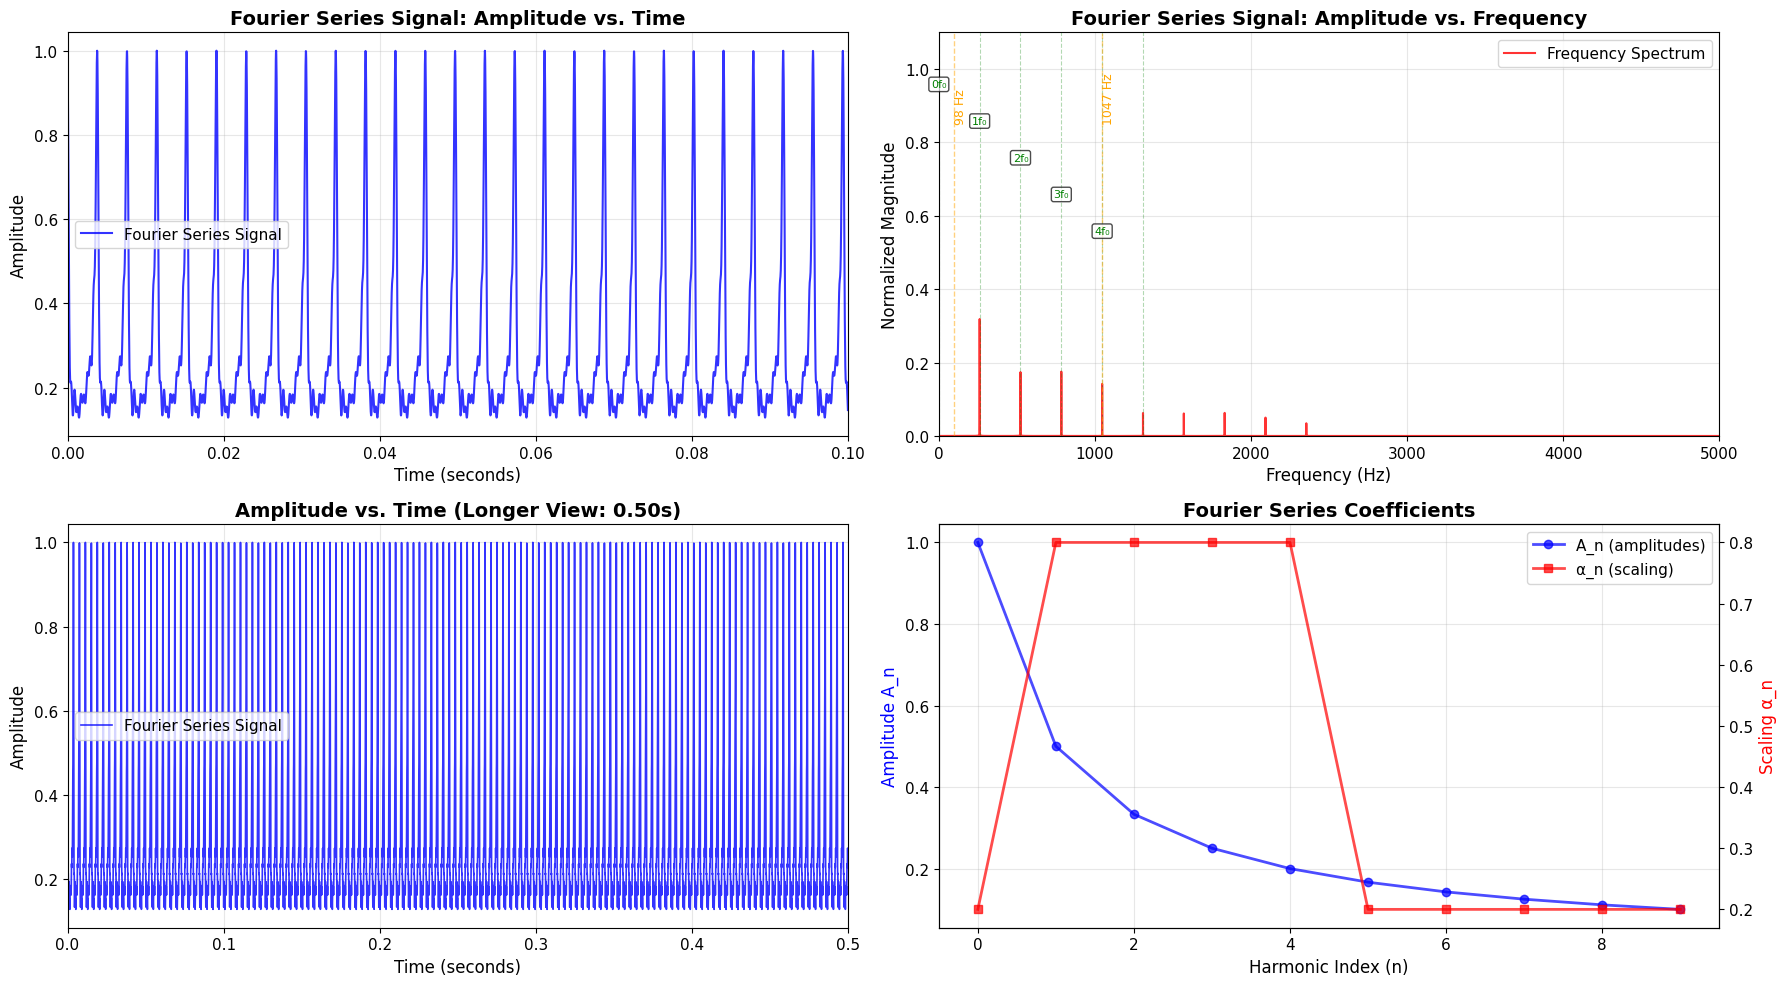


FOURIER SERIES COEFFICIENTS

Harmonic | Frequency (Hz) | A_n      | α_n     | Phase φ_n
----------------------------------------------------------------------
    0   |        0.00  |  1.0000 |  0.2000 |  0.0000
    1   |      261.63  |  0.5000 |  0.8000 |  0.0000
    2   |      523.26  |  0.3333 |  0.8000 |  0.0000
    3   |      784.89  |  0.2500 |  0.8000 |  0.0000
    4   |     1046.52  |  0.2000 |  0.8000 |  0.0000
    5   |     1308.15  |  0.1667 |  0.2000 |  0.0000
    6   |     1569.78  |  0.1429 |  0.2000 |  0.0000
    7   |     1831.41  |  0.1250 |  0.2000 |  0.0000
    8   |     2093.04  |  0.1111 |  0.2000 |  0.0000
    9   |     2354.67  |  0.1000 |  0.2000 |  0.0000


In [19]:
# ============================================================================
# VISUALIZATION: Fourier Series Signal
# ============================================================================

# Compute FFT for frequency domain
fft_fourier = rfft(amplitude_fourier)
frequencies_fourier = rfftfreq(len(amplitude_fourier), time_fourier[1] - time_fourier[0])
magnitude_fourier = np.abs(fft_fourier)
magnitude_fourier_norm = magnitude_fourier / np.max(magnitude_fourier) if np.max(magnitude_fourier) > 0 else magnitude_fourier

# Select time window for display
TIME_WINDOW_FOURIER = min(0.1, time_fourier[-1])
time_mask_fourier = time_fourier <= TIME_WINDOW_FOURIER

# Limit frequency range
freq_mask_fourier = frequencies_fourier <= 5000

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Top Left: Amplitude vs. Time (full view)
ax1 = axes[0, 0]
ax1.plot(time_fourier[time_mask_fourier], amplitude_fourier[time_mask_fourier], 
         'b-', linewidth=1.5, label='Fourier Series Signal', alpha=0.8)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title('Fourier Series Signal: Amplitude vs. Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim([0, TIME_WINDOW_FOURIER])

# Top Right: Amplitude vs. Frequency
ax2 = axes[0, 1]
ax2.plot(frequencies_fourier[freq_mask_fourier], magnitude_fourier_norm[freq_mask_fourier], 
         'r-', linewidth=1.5, label='Frequency Spectrum', alpha=0.8)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Normalized Magnitude', fontsize=12)
ax2.set_title('Fourier Series Signal: Amplitude vs. Frequency', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, 1.1])

# Add vertical lines for fundamental and harmonics
for n in range(min(6, NUM_HARMONICS)):
    freq = n * FUNDAMENTAL_FREQ_HZ
    if freq <= 5000:
        ax2.axvline(x=freq, color='green', linestyle='--', alpha=0.3, linewidth=0.8)
        if n < 5:  # Label first few harmonics
            ax2.text(freq, 0.95 - n*0.1, f'{n}f₀', fontsize=8, color='green', 
                    ha='center', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# Add sasando range markers
ax2.axvline(x=98, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax2.axvline(x=1047, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax2.text(98, 0.85, '98 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='orange')
ax2.text(1047, 0.85, '1047 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='orange')

# Bottom Left: Longer time view
TIME_WINDOW_LONG = min(0.5, time_fourier[-1])
time_mask_long = time_fourier <= TIME_WINDOW_LONG
ax3 = axes[1, 0]
ax3.plot(time_fourier[time_mask_long], amplitude_fourier[time_mask_long], 
         'b-', linewidth=1.2, label='Fourier Series Signal', alpha=0.8)
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Amplitude', fontsize=12)
ax3.set_title(f'Amplitude vs. Time (Longer View: {TIME_WINDOW_LONG:.2f}s)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_xlim([0, TIME_WINDOW_LONG])

# Bottom Right: Coefficient visualization
ax4 = axes[1, 1]
harmonics = np.arange(NUM_HARMONICS)

# Get coefficient values for visualization
A_values = [A_n_coeff(n) if callable(A_n_coeff) else (A_n_coeff[n] if isinstance(A_n_coeff, (list, np.ndarray)) else A_n_coeff) for n in harmonics]
alpha_values = [alpha_n_coeff(n) if callable(alpha_n_coeff) else (alpha_n_coeff[n] if isinstance(alpha_n_coeff, (list, np.ndarray)) else alpha_n_coeff) for n in harmonics]

ax4_twin = ax4.twinx()
line1 = ax4.plot(harmonics, A_values, 'b-o', linewidth=2, markersize=6, label='A_n (amplitudes)', alpha=0.7)
line2 = ax4_twin.plot(harmonics, alpha_values, 'r-s', linewidth=2, markersize=6, label='α_n (scaling)', alpha=0.7)

ax4.set_xlabel('Harmonic Index (n)', fontsize=12)
ax4.set_ylabel('Amplitude A_n', fontsize=12, color='b')
ax4_twin.set_ylabel('Scaling α_n', fontsize=12, color='r')
ax4.set_title('Fourier Series Coefficients', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([-0.5, NUM_HARMONICS - 0.5])

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# Print coefficient information
print("\n" + "="*80)
print("FOURIER SERIES COEFFICIENTS")
print("="*80)
print(f"\nHarmonic | Frequency (Hz) | A_n      | α_n     | Phase φ_n")
print("-" * 70)
for n in range(min(10, NUM_HARMONICS)):
    freq = n * FUNDAMENTAL_FREQ_HZ
    A_val = A_values[n] if n < len(A_values) else 0
    alpha_val = alpha_values[n] if n < len(alpha_values) else 0
    phi_val = phi_n_coeff(n) if callable(phi_n_coeff) else (phi_n_coeff[n] if isinstance(phi_n_coeff, (list, np.ndarray)) and n < len(phi_n_coeff) else 0)
    print(f"  {n:3d}   | {freq:11.2f}  | {A_val:7.4f} | {alpha_val:7.4f} | {phi_val:7.4f}")


In [20]:
# ============================================================================
# CONFIGURATION: Processing Parameters
# ============================================================================
# Choose which processing method to use
USE_FOURIER_MODEL = True  # Set to True to use Fourier series model, False for filter-based

if USE_FOURIER_MODEL:
    # ===== FOURIER SERIES MODEL PARAMETERS =====
    # Define coefficient functions (same as in Step 5)
    def A_n_func(n):
        if n == 0:
            return 1.0
        return 1.0 / (n + 1)
    
    def phi_n_func(n):
        return 0.0
    
    def alpha_n_func(n):
        # Estimate fundamental frequency from signal
        fft_signal = rfft(amplitude_original)
        freqs = rfftfreq(len(amplitude_original), 1/sample_rate)
        magnitude = np.abs(fft_signal)
        mask = (freqs >= 20) & (freqs <= 2000)
        if np.any(mask):
            peak_idx = np.argmax(magnitude[mask])
            fundamental_freq_hz = freqs[mask][peak_idx]
        else:
            fundamental_freq_hz = 261.63
        
        freq_hz = n * fundamental_freq_hz
        # Boost frequencies in sasando range (98-1047 Hz)
        if 98 <= freq_hz <= 1047:
            return 0.8  # Strong resonator response
        else:
            return 0.2  # Weak response outside range
    
    PROCESSING_PARAMS = {
        'omega_0': None,          # Will be estimated from signal
        'num_harmonics': 20,      # Number of harmonics
        'A_n': A_n_func,          # Amplitude coefficients
        'phi_n': phi_n_func,      # Phase coefficients
        'alpha_n': alpha_n_func,  # Frequency-dependent scaling
        'theta': np.pi / 4,       # Phase shift (45 degrees)
        'use_fourier_model': True,
    }
    
    print("Using FOURIER SERIES MODEL for processing")
    print("Mathematical form: f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)")
    print("\nFourier series parameters:")
    for key, value in PROCESSING_PARAMS.items():
        if key != 'A_n' and key != 'phi_n' and key != 'alpha_n':
            print(f"  {key}: {value}")
    
    # Process the signal using Fourier series model
    print("\nProcessing signal with Fourier series model...")
    amplitude_processed = process_signal_fourier_series(
        amplitude_original, sample_rate, time_original, **PROCESSING_PARAMS
    )
    
else:
    # ===== FILTER-BASED PARAMETERS (legacy method) =====
    PROCESSING_PARAMS = {
        'f_low': 98,              # Low frequency cutoff (Hz)
        'f_high': 1047,           # High frequency cutoff (Hz)
        'gain_boost': 1.5,        # Gain multiplier
        'resonance_q': 10.0,      # Q factor for resonance
        'resonance_freq': 500,    # Resonance frequency (Hz)
        'enable_bandpass': True,  # Enable bandpass filtering
        'enable_resonance': False, # Enable resonant peak filter
        'use_fourier_model': False,
    }
    
    print("Using FILTER-BASED approach for processing")
    print("\nFilter parameters:")
    for key, value in PROCESSING_PARAMS.items():
        if key != 'use_fourier_model':
            print(f"  {key}: {value}")
    
    # Process the signal using filter-based approach
    print("\nProcessing signal with filters...")
    amplitude_processed = process_signal(amplitude_original, sample_rate, **{k:v for k,v in PROCESSING_PARAMS.items() if k != 'use_fourier_model'})

print(f"\n✓ Signal processed!")
print(f"  Original amplitude range: [{np.min(amplitude_original):.4f}, {np.max(amplitude_original):.4f}]")
print(f"  Processed amplitude range: [{np.min(amplitude_processed):.4f}, {np.max(amplitude_processed):.4f}]")


Using FOURIER SERIES MODEL for processing
Mathematical form: f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)

Fourier series parameters:
  omega_0: None
  num_harmonics: 20
  theta: 0.7853981633974483
  use_fourier_model: True

Processing signal with Fourier series model...
  Estimated fundamental: 129.89 Hz (ω₀ = 816.12 rad/s)

✓ Signal processed!
  Original amplitude range: [-0.0707, 0.0586]
  Processed amplitude range: [-0.0598, 0.0707]


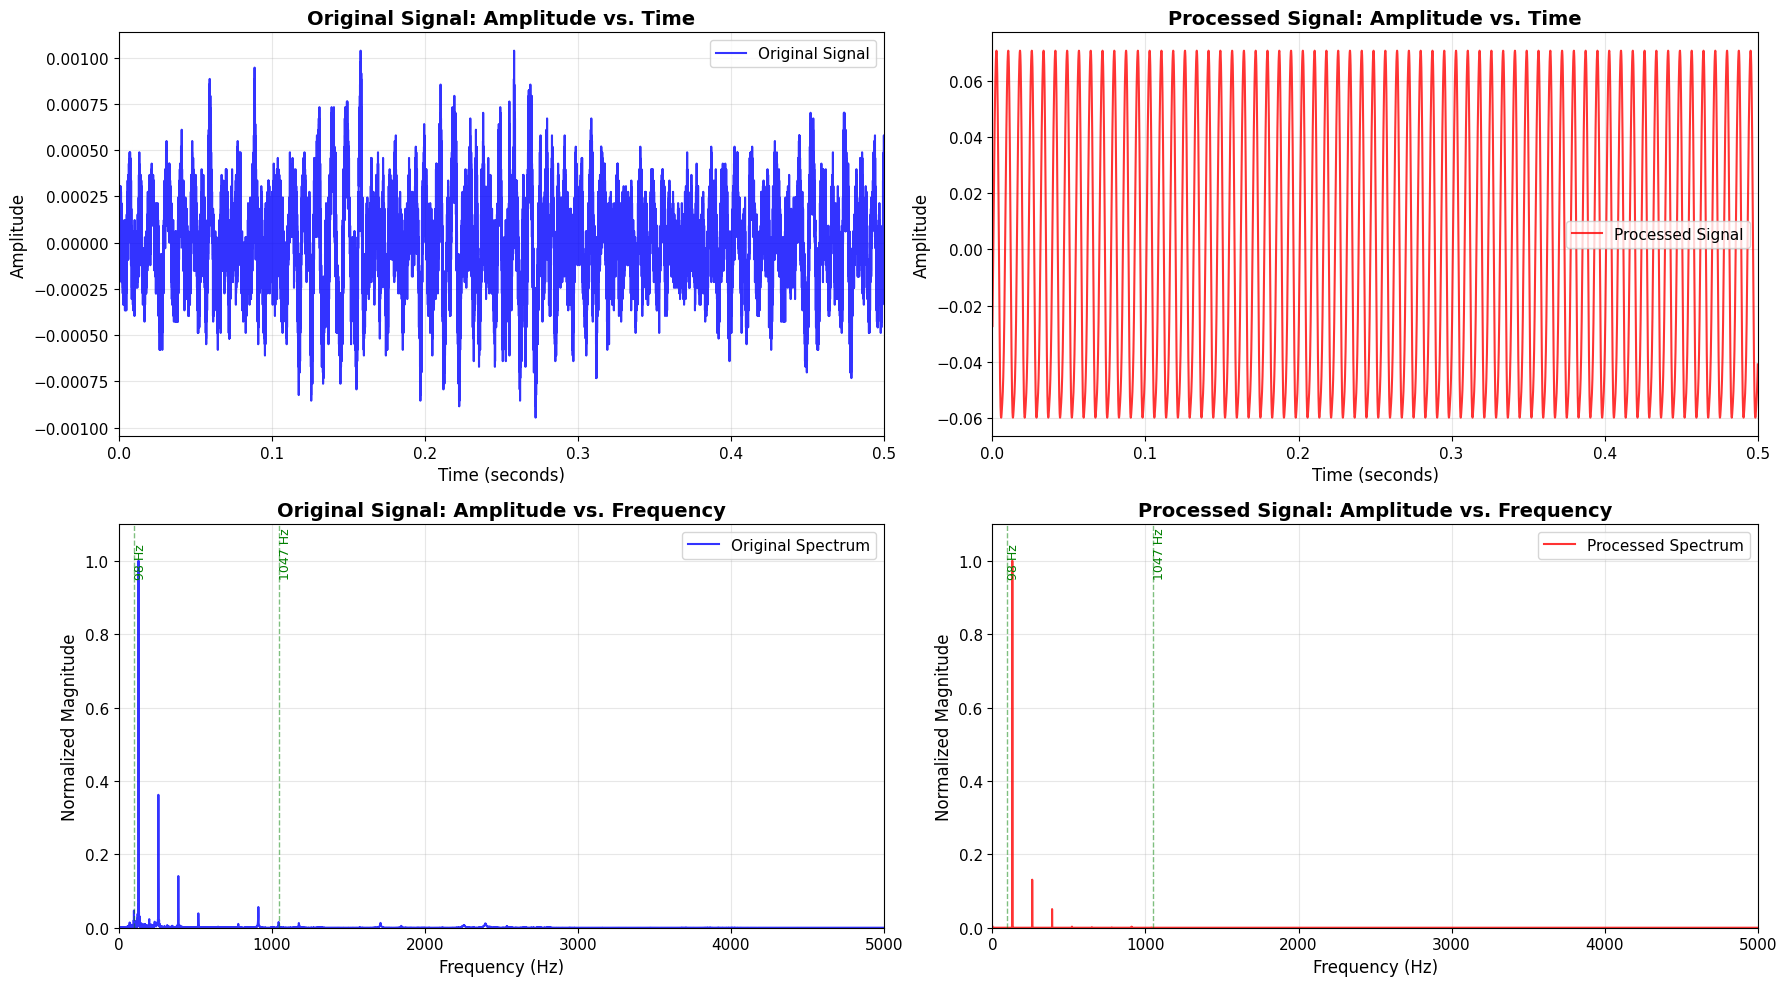


SIGNAL STATISTICS

TIME DOMAIN:
  Original - Mean: 0.000003, Std: 0.008639, RMS: 0.008639
  Processed - Mean: 0.000097, Std: 0.047334, RMS: 0.047334
  Difference - Mean: 0.039566, Max: 0.101951

FREQUENCY DOMAIN:
  Energy in sasando range (98-1047 Hz):
    Original: 7.80e+06 (98.9% of total)
    Processed: 2.37e+08 (100.0% of total)


In [21]:
# ============================================================================
# COMPARISON: Amplitude vs. Time & Amplitude vs. Frequency
# ============================================================================

# Compute FFT for frequency domain plots
fft_original = rfft(amplitude_original)
fft_processed = rfft(amplitude_processed)
frequencies = rfftfreq(len(amplitude_original), 1/sample_rate)

# Calculate magnitude spectra
magnitude_original = np.abs(fft_original)
magnitude_processed = np.abs(fft_processed)

# Normalize for visualization
magnitude_original_norm = magnitude_original / np.max(magnitude_original) if np.max(magnitude_original) > 0 else magnitude_original
magnitude_processed_norm = magnitude_processed / np.max(magnitude_processed) if np.max(magnitude_processed) > 0 else magnitude_processed

# Select a time window to display (first N seconds, or full signal if shorter)
TIME_WINDOW = min(0.5, time_original[-1])  # Show first 0.5 seconds
time_mask = time_original <= TIME_WINDOW

# Limit frequency range for clarity (up to 5000 Hz)
freq_mask = frequencies <= 5000

# Create figure with 2x2 subplots: Original and Processed for both Time and Frequency
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# ===== TOP ROW: TIME DOMAIN (Amplitude vs. Time) =====

# Top Left: Original - Amplitude vs. Time
ax1 = axes[0, 0]
ax1.plot(time_original[time_mask], amplitude_original[time_mask], 
         'b-', linewidth=1.5, label='Original Signal', alpha=0.8)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title('Original Signal: Amplitude vs. Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim([0, TIME_WINDOW])

# Top Right: Processed - Amplitude vs. Time
ax2 = axes[0, 1]
ax2.plot(time_original[time_mask], amplitude_processed[time_mask], 
         'r-', linewidth=1.5, label='Processed Signal', alpha=0.8)
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Amplitude', fontsize=12)
ax2.set_title('Processed Signal: Amplitude vs. Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([0, TIME_WINDOW])

# ===== BOTTOM ROW: FREQUENCY DOMAIN (Amplitude vs. Frequency) =====

# Bottom Left: Original - Amplitude vs. Frequency
ax3 = axes[1, 0]
ax3.plot(frequencies[freq_mask], magnitude_original_norm[freq_mask], 
         'b-', linewidth=1.5, label='Original Spectrum', alpha=0.8)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Normalized Magnitude', fontsize=12)
ax3.set_title('Original Signal: Amplitude vs. Frequency', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_xlim([0, 5000])
ax3.set_ylim([0, 1.1])

# Add vertical lines for sasando resonator range
ax3.axvline(x=98, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax3.axvline(x=1047, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax3.text(98, 0.95, '98 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')
ax3.text(1047, 0.95, '1047 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')

# Bottom Right: Processed - Amplitude vs. Frequency
ax4 = axes[1, 1]
ax4.plot(frequencies[freq_mask], magnitude_processed_norm[freq_mask], 
         'r-', linewidth=1.5, label='Processed Spectrum', alpha=0.8)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Normalized Magnitude', fontsize=12)
ax4.set_title('Processed Signal: Amplitude vs. Frequency', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xlim([0, 5000])
ax4.set_ylim([0, 1.1])

# Add vertical lines for sasando resonator range
ax4.axvline(x=98, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.axvline(x=1047, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.text(98, 0.95, '98 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')
ax4.text(1047, 0.95, '1047 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')

plt.tight_layout()
plt.show()

# Calculate statistics
print("\n" + "="*80)
print("SIGNAL STATISTICS")
print("="*80)
print(f"\nTIME DOMAIN:")
print(f"  Original - Mean: {np.mean(amplitude_original):.6f}, Std: {np.std(amplitude_original):.6f}, RMS: {np.sqrt(np.mean(amplitude_original**2)):.6f}")
print(f"  Processed - Mean: {np.mean(amplitude_processed):.6f}, Std: {np.std(amplitude_processed):.6f}, RMS: {np.sqrt(np.mean(amplitude_processed**2)):.6f}")
print(f"  Difference - Mean: {np.mean(np.abs(amplitude_processed - amplitude_original)):.6f}, Max: {np.max(np.abs(amplitude_processed - amplitude_original)):.6f}")

# Energy in sasando range
sasando_mask = (frequencies >= 98) & (frequencies <= 1047)
energy_original = np.sum(magnitude_original[sasando_mask]**2)
energy_processed = np.sum(magnitude_processed[sasando_mask]**2)
total_energy_original = np.sum(magnitude_original**2)
total_energy_processed = np.sum(magnitude_processed**2)

print(f"\nFREQUENCY DOMAIN:")
print(f"  Energy in sasando range (98-1047 Hz):")
print(f"    Original: {energy_original:.2e} ({100*energy_original/total_energy_original:.1f}% of total)")
print(f"    Processed: {energy_processed:.2e} ({100*energy_processed/total_energy_processed:.1f}% of total)")


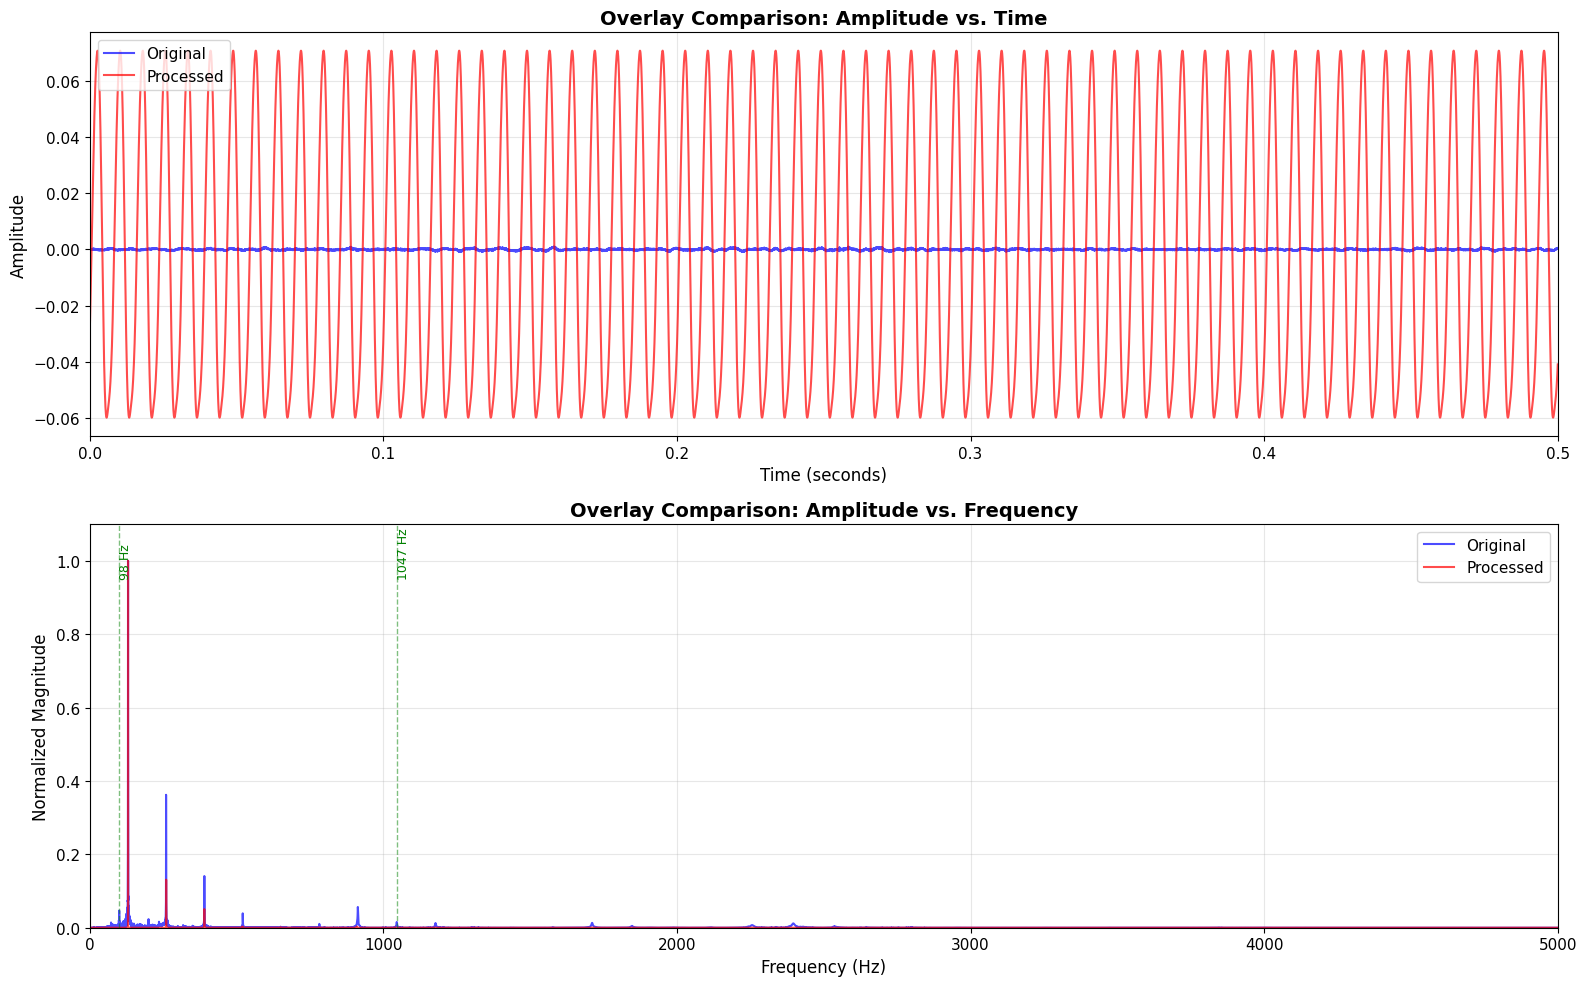


DETAILED FREQUENCY ANALYSIS

Top 5 frequency peaks in original signal:
  129.89 Hz (magnitude: 1.35e+03)
  259.47 Hz (magnitude: 4.89e+02)
  389.88 Hz (magnitude: 1.90e+02)

Top 5 frequency peaks in processed signal:
  129.89 Hz (magnitude: 1.52e+04)
  259.78 Hz (magnitude: 1.99e+03)


In [22]:
# ============================================================================
# COMPARISON: Overlay View (Original vs. Processed)
# ============================================================================

# Create overlay comparison plots showing both signals together
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Amplitude vs. Time (Overlay)
ax1 = axes[0]
ax1.plot(time_original[time_mask], amplitude_original[time_mask], 
         'b-', linewidth=1.5, label='Original', alpha=0.7)
ax1.plot(time_original[time_mask], amplitude_processed[time_mask], 
         'r-', linewidth=1.5, label='Processed', alpha=0.7)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title('Overlay Comparison: Amplitude vs. Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim([0, TIME_WINDOW])

# Bottom: Amplitude vs. Frequency (Overlay)
ax2 = axes[1]
ax2.plot(frequencies[freq_mask], magnitude_original_norm[freq_mask], 
         'b-', linewidth=1.5, label='Original', alpha=0.7)
ax2.plot(frequencies[freq_mask], magnitude_processed_norm[freq_mask], 
         'r-', linewidth=1.5, label='Processed', alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Normalized Magnitude', fontsize=12)
ax2.set_title('Overlay Comparison: Amplitude vs. Frequency', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, 1.1])

# Add vertical lines for sasando resonator range
ax2.axvline(x=98, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax2.axvline(x=1047, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax2.text(98, 0.95, '98 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')
ax2.text(1047, 0.95, '1047 Hz', rotation=90, verticalalignment='bottom', fontsize=9, color='green')

plt.tight_layout()
plt.show()

# Find dominant frequencies
def find_dominant_freqs(magnitude, freqs, n_peaks=5):
    """Find top N frequency peaks"""
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(magnitude, height=np.max(magnitude)*0.1, distance=10)
    if len(peaks) > 0:
        peak_mags = magnitude[peaks]
        sorted_indices = np.argsort(peak_mags)[::-1][:n_peaks]
        return [(freqs[peaks[i]], peak_mags[i]) for i in sorted_indices]
    return []

print("\n" + "="*80)
print("DETAILED FREQUENCY ANALYSIS")
print("="*80)
print("\nTop 5 frequency peaks in original signal:")
for freq, mag in find_dominant_freqs(magnitude_original, frequencies):
    print(f"  {freq:.2f} Hz (magnitude: {mag:.2e})")

print("\nTop 5 frequency peaks in processed signal:")
for freq, mag in find_dominant_freqs(magnitude_processed, frequencies):
    print(f"  {freq:.2f} Hz (magnitude: {mag:.2e})")


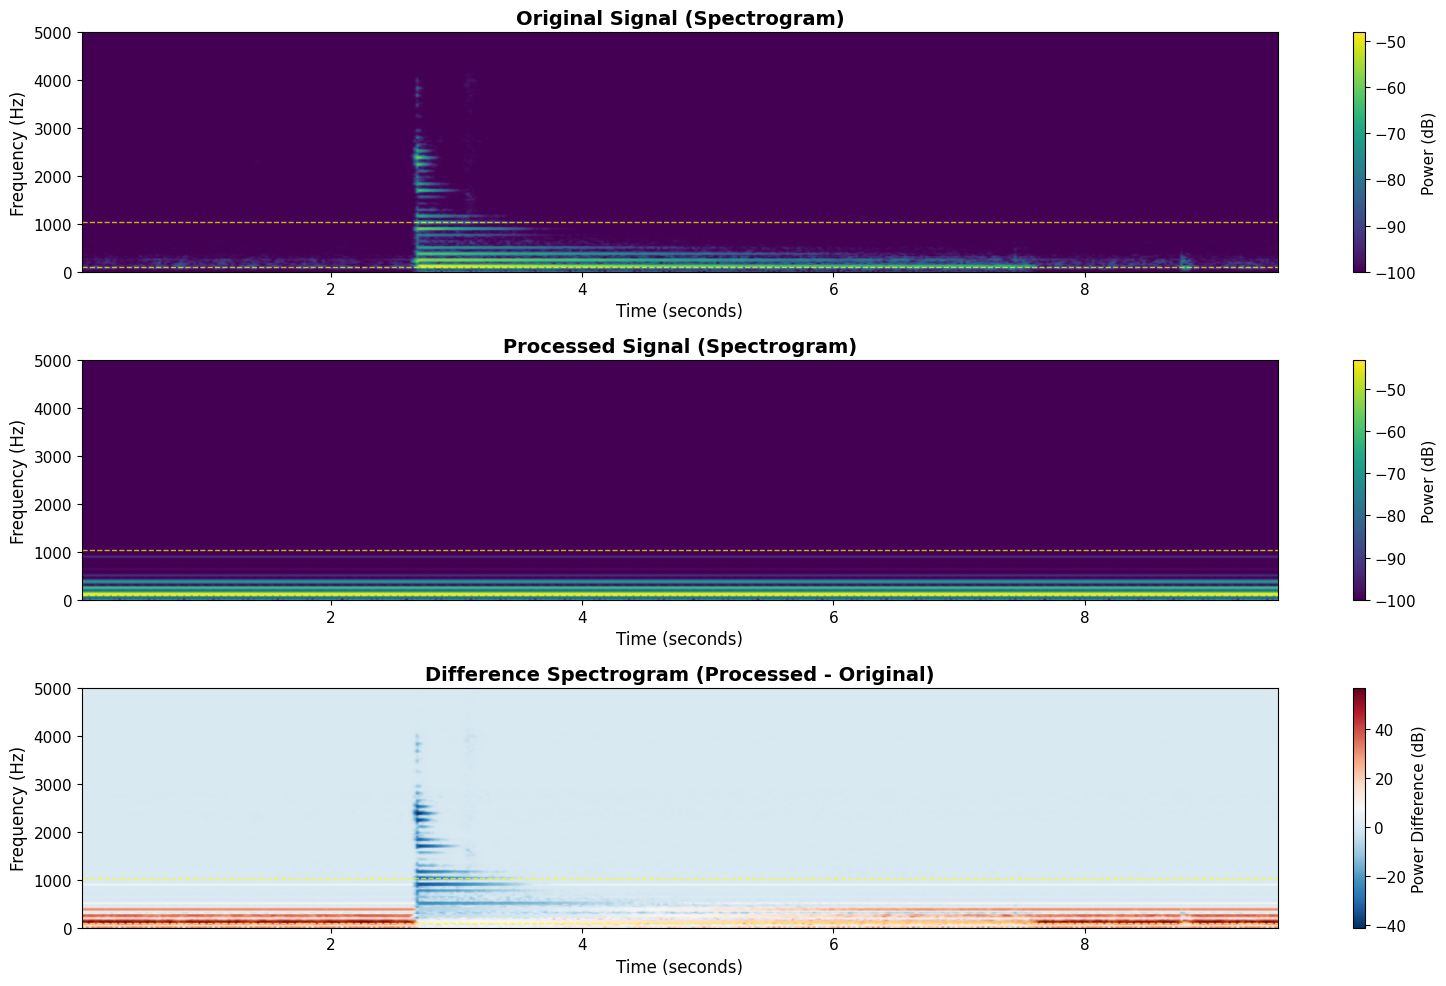

In [23]:
# ============================================================================
# COMPARISON: Spectrogram
# ============================================================================

# Compute spectrograms
def compute_spectrogram(signal, sample_rate, nperseg=2048):
    """Compute spectrogram using scipy"""
    frequencies_spec, times_spec, Sxx = scipy_signal.spectrogram(
        signal, 
        sample_rate, 
        nperseg=nperseg,
        noverlap=nperseg//2,
        window='hann'
    )
    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    return frequencies_spec, times_spec, Sxx_db

freqs_spec, times_spec, Sxx_original = compute_spectrogram(amplitude_original, sample_rate)
_, _, Sxx_processed = compute_spectrogram(amplitude_processed, sample_rate)

# Limit frequency range
freq_mask_spec = freqs_spec <= 5000

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot 1: Original spectrogram
ax1 = axes[0]
im1 = ax1.pcolormesh(times_spec, freqs_spec[freq_mask_spec], 
                     Sxx_original[freq_mask_spec, :], 
                     shading='gouraud', cmap='viridis')
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Frequency (Hz)', fontsize=12)
ax1.set_title('Original Signal (Spectrogram)', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 5000])
plt.colorbar(im1, ax=ax1, label='Power (dB)')

# Plot 2: Processed spectrogram
ax2 = axes[1]
im2 = ax2.pcolormesh(times_spec, freqs_spec[freq_mask_spec], 
                     Sxx_processed[freq_mask_spec, :], 
                     shading='gouraud', cmap='viridis')
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=12)
ax2.set_title('Processed Signal (Spectrogram)', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 5000])
plt.colorbar(im2, ax=ax2, label='Power (dB)')

# Plot 3: Difference spectrogram
ax3 = axes[2]
Sxx_diff = Sxx_processed - Sxx_original
im3 = ax3.pcolormesh(times_spec, freqs_spec[freq_mask_spec], 
                     Sxx_diff[freq_mask_spec, :], 
                     shading='gouraud', cmap='RdBu_r')
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Difference Spectrogram (Processed - Original)', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 5000])
plt.colorbar(im3, ax=ax3, label='Power Difference (dB)')

# Add horizontal lines for sasando range
for ax in axes:
    ax.axhline(y=98, color='yellow', linestyle='--', alpha=0.7, linewidth=1)
    ax.axhline(y=1047, color='yellow', linestyle='--', alpha=0.7, linewidth=1)

plt.tight_layout()
plt.show()


## Summary

This notebook provides a complete framework for:
1. ✅ Loading audio files
2. ✅ Defining custom processing functions with configurable parameters
3. ✅ Comparing original vs processed signals in multiple domains
4. ✅ Visualizing differences and understanding the transformation

### Next Steps:
- Adjust parameters in **Step 3** and re-run the comparison cells
- Modify the `process_signal()` function in **Step 2** to add your own processing logic
- Try different audio files to see how your processing affects different signals
- Use the transfer function plot to understand how your processing modifies frequencies


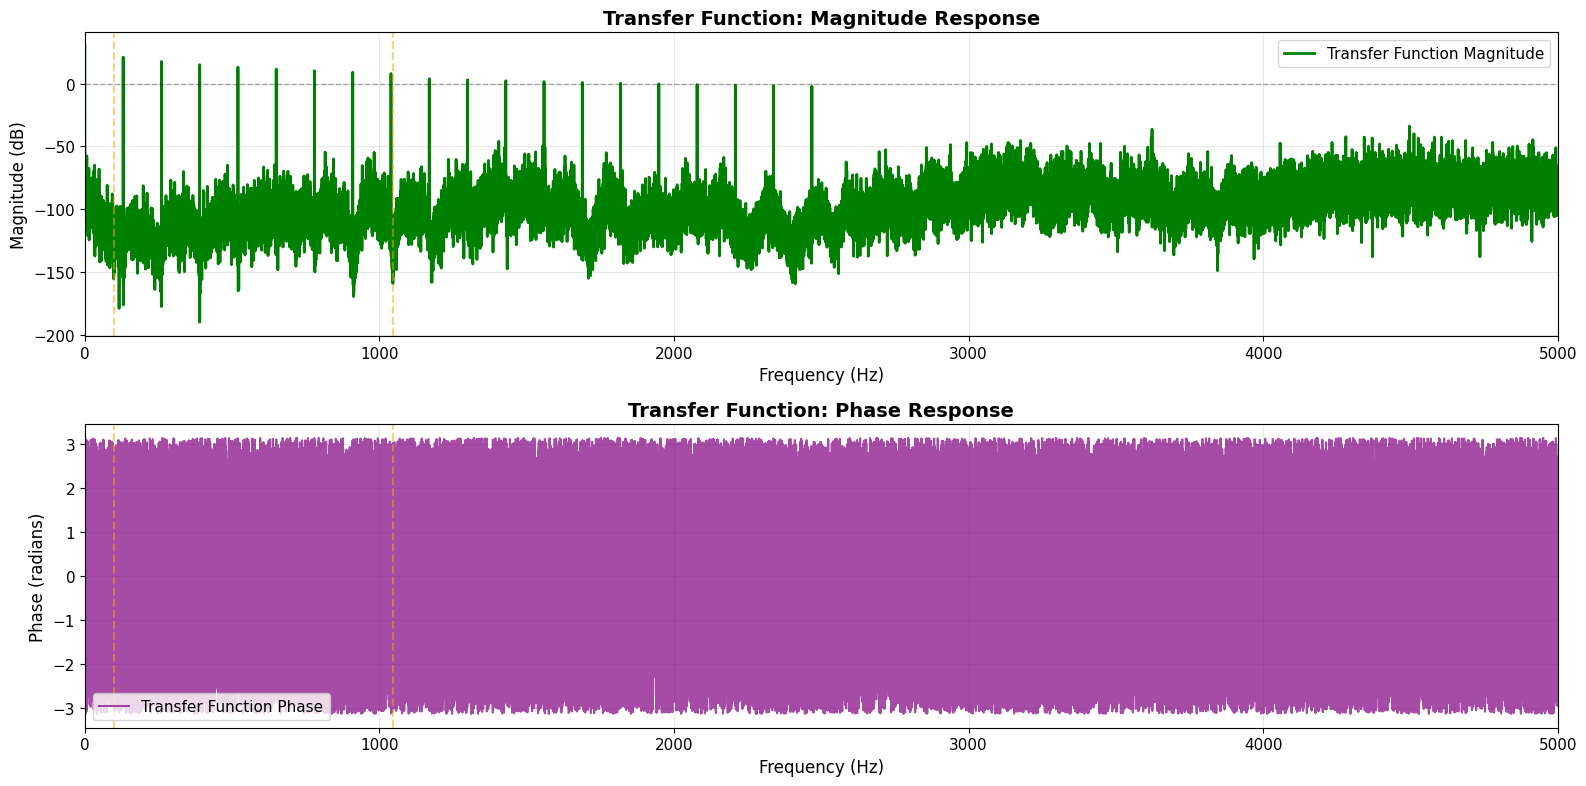


TRANSFER FUNCTION STATISTICS

Gain in sasando range (98-1047 Hz):
  Average: -112.65 dB
  Maximum: 21.06 dB
  Minimum: -189.93 dB

Gain outside sasando range:
  Average: -82.63 dB


In [24]:
# ============================================================================
# COMPARISON: Transfer Function / Frequency Response
# ============================================================================

# Calculate the transfer function (H(f) = Y(f) / X(f))
# This shows how your processing function modifies each frequency

# Avoid division by zero
epsilon = 1e-10
transfer_function = np.divide(fft_processed, fft_original + epsilon)
transfer_magnitude = np.abs(transfer_function)
transfer_phase = np.angle(transfer_function)

# Convert magnitude to dB
transfer_magnitude_db = 20 * np.log10(transfer_magnitude + epsilon)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Plot 1: Magnitude response
ax1 = axes[0]
ax1.plot(frequencies[freq_mask], transfer_magnitude_db[freq_mask], 
         'g-', linewidth=2, label='Transfer Function Magnitude')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Magnitude (dB)', fontsize=12)
ax1.set_title('Transfer Function: Magnitude Response', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim([0, 5000])

# Add vertical lines for sasando range
ax1.axvline(x=98, color='orange', linestyle='--', alpha=0.5, label='Sasando range (98-1047 Hz)')
ax1.axvline(x=1047, color='orange', linestyle='--', alpha=0.5)

# Plot 2: Phase response
ax2 = axes[1]
ax2.plot(frequencies[freq_mask], transfer_phase[freq_mask], 
         'purple', linewidth=1.5, label='Transfer Function Phase', alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Phase (radians)', fontsize=12)
ax2.set_title('Transfer Function: Phase Response', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([0, 5000])

# Add vertical lines for sasando range
ax2.axvline(x=98, color='orange', linestyle='--', alpha=0.5, label='Sasando range (98-1047 Hz)')
ax2.axvline(x=1047, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print some statistics about the transfer function
print("\n" + "="*80)
print("TRANSFER FUNCTION STATISTICS")
print("="*80)

# Average gain in sasando range
sasando_mask = (frequencies >= 98) & (frequencies <= 1047)
avg_gain_db = np.mean(transfer_magnitude_db[sasando_mask])
max_gain_db = np.max(transfer_magnitude_db[sasando_mask])
min_gain_db = np.min(transfer_magnitude_db[sasando_mask])

print(f"\nGain in sasando range (98-1047 Hz):")
print(f"  Average: {avg_gain_db:.2f} dB")
print(f"  Maximum: {max_gain_db:.2f} dB")
print(f"  Minimum: {min_gain_db:.2f} dB")

# Average gain outside sasando range
outside_mask = (frequencies < 98) | (frequencies > 1047)
avg_gain_outside_db = np.mean(transfer_magnitude_db[outside_mask])
print(f"\nGain outside sasando range:")
print(f"  Average: {avg_gain_outside_db:.2f} dB")
